In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd
import scipy.stats as stats
import radiomics
import SimpleITK as sitk
from radiomics import base, cShape, deprecated

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
h1 = nib.load('s01.nii.gz')
print(h1.header['pixdim'])
h2 = nib.load('s02.nii.gz')
print(h2.header['pixdim'])

[-1.  1.  1.  2.  1.  1.  1.  1.]
[-1.         1.         1.         1.9999906  1.         1.
  1.         1.       ]


In [3]:
# calculate voxel volume
dv1 = np.prod(h1.header['pixdim'][1:4])
dv2 = np.prod(h2.header['pixdim'][1:4])
dv1, dv2

(2.0, 1.9999906)

## 1. Segmentation

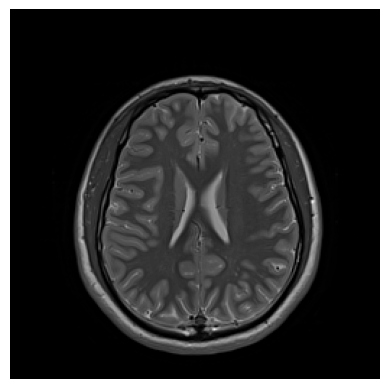

In [4]:
mri1 = np.rot90(h1.get_fdata()[:,:,24])
plt.imshow(mri1,cmap='gray')
plt.axis('off')
plt.show()

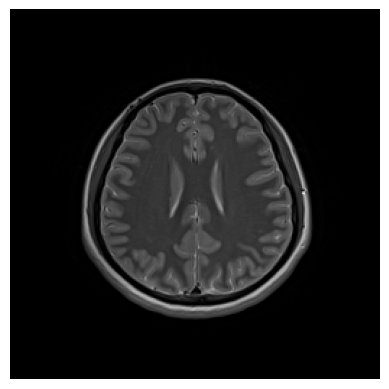

In [5]:
mri2 = np.rot90(h2.get_fdata()[:,:,24])
plt.imshow(mri2,cmap='gray')
plt.axis('off')
plt.show()

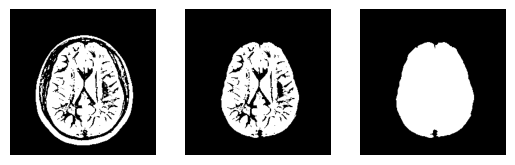

mask volume: 35532.0 mm^3


In [6]:
th = 600
seg = nd.gaussian_filter(mri1,0.5)>th
l,m = nd.label(seg)
l_mode = stats.mode(l[l>0])
L = l==l_mode.mode
bmask = nd.binary_fill_holes(L) # fill holes
plt.subplot(131)
plt.imshow(seg,cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(L, cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(bmask,cmap='gray')
plt.axis('off')
plt.show()

bmask_vol = np.sum(bmask[bmask>0]) * dv1
print(f'mask volume: {bmask_vol} mm^3')

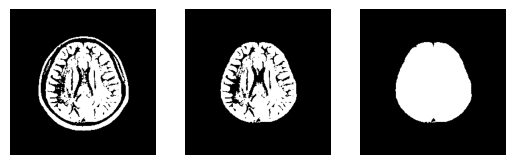

mask volume: 29667.860300302505 mm^3


In [12]:
th = 560
seg_2 = nd.gaussian_filter(mri2,0.5)>th
l,m = nd.label(seg_2)
l_mode = stats.mode(l[l>0])
L2 = l==l_mode.mode
bmask2 = nd.binary_fill_holes(L2) # fill holes
plt.subplot(131)
plt.imshow(seg_2,cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(L2, cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(bmask2,cmap='gray')
plt.axis('off')
plt.show()

bmask_vol_2 = np.sum(bmask2[bmask2>0]) * dv2
print(f'mask volume: {bmask_vol_2} mm^3')

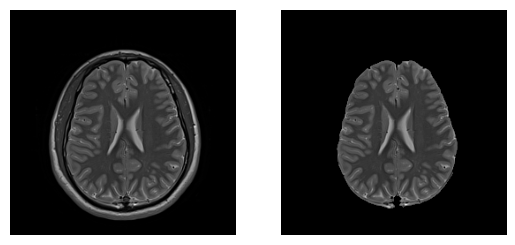

In [13]:
mri_masked = mri1.copy()
mri_masked[bmask==0]=0
plt.subplot(121)
plt.imshow(mri1,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(mri_masked,cmap='gray')
plt.axis('off')
plt.show()

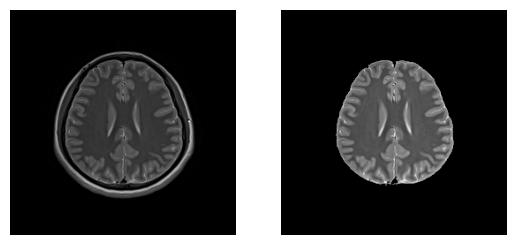

In [14]:
mri_masked_2 = mri2.copy()
mri_masked_2[bmask2==0]=0
plt.subplot(121)
plt.imshow(mri2,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(mri_masked_2,cmap='gray')
plt.axis('off')
plt.show()

after iteration #1 : [   0  615  961 1646]
E: 608
after iteration #2 : [   0  626  954 1525]
E: 139


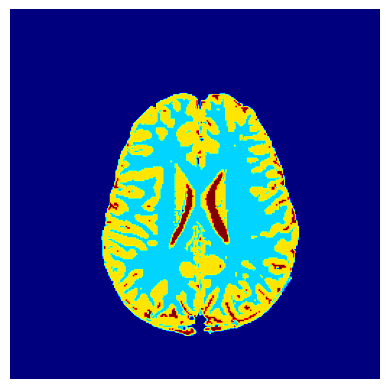

In [70]:
img = mri_masked.copy()
E = 1e6
eps = 500
m_vals = np.array([100, 500, 1000, 2000])
m_vals_new = m_vals.copy()
D = np.zeros((len(m_vals),img.shape[0],img.shape[1]))
n = 0
while E>eps:
  n = n+1
  for k in range(len(m_vals)):
    D[k] = np.abs(img-m_vals[k])
  R = np.argmin(D,axis=0)
  for k in range(len(m_vals)):
    m_vals_new[k] = np.mean(img[R==k])
  print(f'after iteration #{n} : {m_vals_new}')
  E = np.sum(np.abs(m_vals_new - m_vals))
  print('E:',E)
  m_vals = m_vals_new.copy()

plt.imshow(R,cmap='jet')
plt.axis('off')
plt.show()

after iteration #1 : [   0  586  917 1569]
E2: 700
after iteration #2 : [   0  586  904 1376]
E2: 206
after iteration #3 : [   0  584  889 1284]
E2: 109


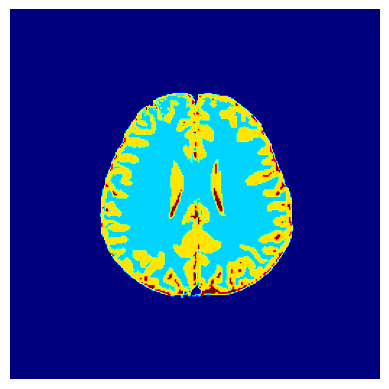

In [71]:
img2 = mri_masked_2.copy()
E2 = 1e6
eps = 200
m_vals2 = np.array([100, 500, 1000, 2000])
m_vals_new2 = m_vals2.copy()
D2 = np.zeros((len(m_vals2),img2.shape[0],img2.shape[1]))
n = 0
while E2>eps:
  n = n+1
  for k in range(len(m_vals2)):
    D2[k] = np.abs(img2-m_vals2[k])
  R2 = np.argmin(D2,axis=0)
  for k in range(len(m_vals2)):
    m_vals_new2[k] = np.mean(img2[R2==k])
  print(f'after iteration #{n} : {m_vals_new2}')
  E2 = np.sum(np.abs(m_vals_new2 - m_vals2))
  print('E2:',E2)
  m_vals2 = m_vals_new2.copy()

plt.imshow(R2,cmap='jet')
plt.axis('off')
plt.show()

## 2. Feature Extraction

In [72]:
wm_vol = np.sum(R==1)*dv1
gm_vol = np.sum(R==2)*dv1
csf_vol = np.sum(R==3)*dv1
# region featuring
print(f'## volume features s01 ##')
print(f'WM: {wm_vol} mm^3, GM: {gm_vol}mm^3, CSF: {csf_vol}mm^3')
wm_mean = np.mean(mri1[R==1])
gm_mean = np.mean(mri1[R==2])
csf_mean = np.mean(mri1[R==3])
# intensity featuring
print(f'## intensity features s01 ##')
print(f'WM mean: {wm_mean}, GM mean: {gm_mean}, CSF mean: {csf_mean}')


## volume features s01 ##
WM: 17994.0 mm^3, GM: 15776.0mm^3, CSF: 1726.0mm^3
## intensity features s01 ##
WM mean: 626.8299433144382, GM mean: 954.8722109533469, CSF mean: 1525.5005793742757


In [73]:
wm_vol2 = np.sum(R2==1)*dv2
gm_vol2 = np.sum(R2==2)*dv2
csf_vol2 = np.sum(R2==3)*dv2
# region featuring
print(f'## volume features s02##')
print(f'WM: {wm_vol2} mm^3, GM: {gm_vol2}mm^3, CSF: {csf_vol2}mm^3')
wm_mean2 = np.mean(mri2[R2==1])
gm_mean2 = np.mean(mri2[R2==2])
csf_mean2 = np.mean(mri2[R2==3])
# intensity featuring
print(f'## intensity features s02##')
print(f'WM mean: {wm_mean2}, GM mean: {gm_mean2}, CSF mean: {csf_mean2}')


## volume features s02##
WM: 17937.91553413868 mm^3, GM: 10821.949041724205mm^3, CSF: 905.9957338571548mm^3
## intensity features s02##
WM mean: 584.4437506968446, GM mean: 889.5695804841988, CSF mean: 1284.9249448123621


## Excersice
- s02.nii.gz에 대해서도 비슷한 위치에 슬라이스에 대해 같은 feature를 추출하여 s01.nii.gz의 결과와 비교하자.
- feature를 12개 이상 추가하여 같은 작업을 반복하자.

### Volume Features

In [74]:
wm_vol = np.sum(R==1)*dv1
gm_vol = np.sum(R==2)*dv1
csf_vol = np.sum(R==3)*dv1
print(f'## volume features s01 ##')
print(f'WM: {wm_vol} mm^3, GM: {gm_vol}mm^3, CSF: {csf_vol}mm^3')
wm_vol2 = np.sum(R2==1)*dv2
gm_vol2 = np.sum(R2==2)*dv2
csf_vol2 = np.sum(R2==3)*dv2
print(f'## volume features s02 ##')
print(f'WM: {wm_vol2} mm^3, GM: {gm_vol2}mm^3, CSF: {csf_vol2}mm^3')

## volume features s01 ##
WM: 17994.0 mm^3, GM: 15776.0mm^3, CSF: 1726.0mm^3
## volume features s02 ##
WM: 17937.91553413868 mm^3, GM: 10821.949041724205mm^3, CSF: 905.9957338571548mm^3


### Intensity features

In [75]:
wm_mean = np.mean(mri1[R==1])
gm_mean = np.mean(mri1[R==2])
csf_mean = np.mean(mri1[R==3])
# intensity featuring
print(f'## intensity features s01 ##')
print(f'WM mean: {wm_mean}, GM mean: {gm_mean}, CSF mean: {csf_mean}')
wm_mean2 = np.mean(mri2[R2==1])
gm_mean2 = np.mean(mri2[R2==2])
csf_mean2 = np.mean(mri2[R2==3])
# intensity featuring
print(f'## intensity features s02 ##')
print(f'WM mean: {wm_mean2}, GM mean: {gm_mean2}, CSF mean: {csf_mean2}')

## intensity features s01 ##
WM mean: 626.8299433144382, GM mean: 954.8722109533469, CSF mean: 1525.5005793742757
## intensity features s02 ##
WM mean: 584.4437506968446, GM mean: 889.5695804841988, CSF mean: 1284.9249448123621


### Total energy

In [76]:
# Total Energy
wm_energy = np.sum(mri1[R==1]**2) * dv1
gm_energy = np.sum(mri1[R==2]**2) * dv1
csf_energy = np.sum(mri1[R==3]**2) * dv1
print(f'## energy features s01 ##')
print(f'WM energy: {wm_energy}, GM energy: {gm_energy}, CSF energy: {csf_energy}')
wm_energy2 = np.sum(mri2[R2==1]**2) * dv2
gm_energy2 = np.sum(mri2[R2==2]**2) * dv2
csf_energy2 = np.sum(mri2[R2==3]**2) * dv2
print(f'## energy features s02 ##')
print(f'WM energy: {wm_energy2}, GM energy: {gm_energy2}, CSF energy: {csf_energy2}')

## energy features s01 ##
WM energy: 7163018954.0, GM energy: 14580888060.0, CSF energy: 4061246694.0
## energy features s02 ##
WM energy: 6196654953.258638, GM energy: 8656680199.518549, CSF energy: 1510250926.546884


### Entropy

In [77]:
# Entropy
wm_entropy = stats.entropy(mri1[R==1])
gm_entropy = stats.entropy(mri1[R==2])
csf_entropy = stats.entropy(mri1[R==3])
print(f'## entropy features s01 ##')
print(f'WM entropy: {wm_entropy}, GM entropy: {gm_entropy}, CSF entropy: {csf_entropy}')
wm_entropy2 = stats.entropy(mri2[R2==1])
gm_entropy2 = stats.entropy(mri2[R2==2])
csf_entropy2 = stats.entropy(mri2[R2==3])
print(f'## entropy features s02 ##')
print(f'WM entropy: {wm_entropy2}, GM entropy: {gm_entropy2}, CSF entropy: {csf_entropy2}')

## entropy features s01 ##
WM entropy: 9.098058852413617, GM entropy: 8.966450624592902, CSF entropy: 6.75507751693203
## entropy features s02 ##
WM entropy: 9.095917993241363, GM entropy: 8.590853856674542, CSF entropy: 6.1112286401023574


### Surface Area

In [78]:
def boundary_extraction(R, dv, kernel, tag):
    R = (R==tag).astype(np.int8)
    e = nd.binary_erosion(R, kernel) 
    boundary = R - e
    return boundary, np.sum(boundary)*dv
def plot_boundary_2d(wm, gm, csf):
    plt.figure(figsize=(16,8))
    plt.subplot(131)
    plt.imshow(wm, cmap= 'gray')
    plt.title('WM boundary')
    plt.subplot(132)
    plt.imshow(gm, cmap= 'gray')
    plt.title('GM boundary')
    plt.subplot(133)
    plt.imshow(csf, cmap= 'gray')
    plt.title('CSF boundary')
    plt.colorbar()
    plt.show()

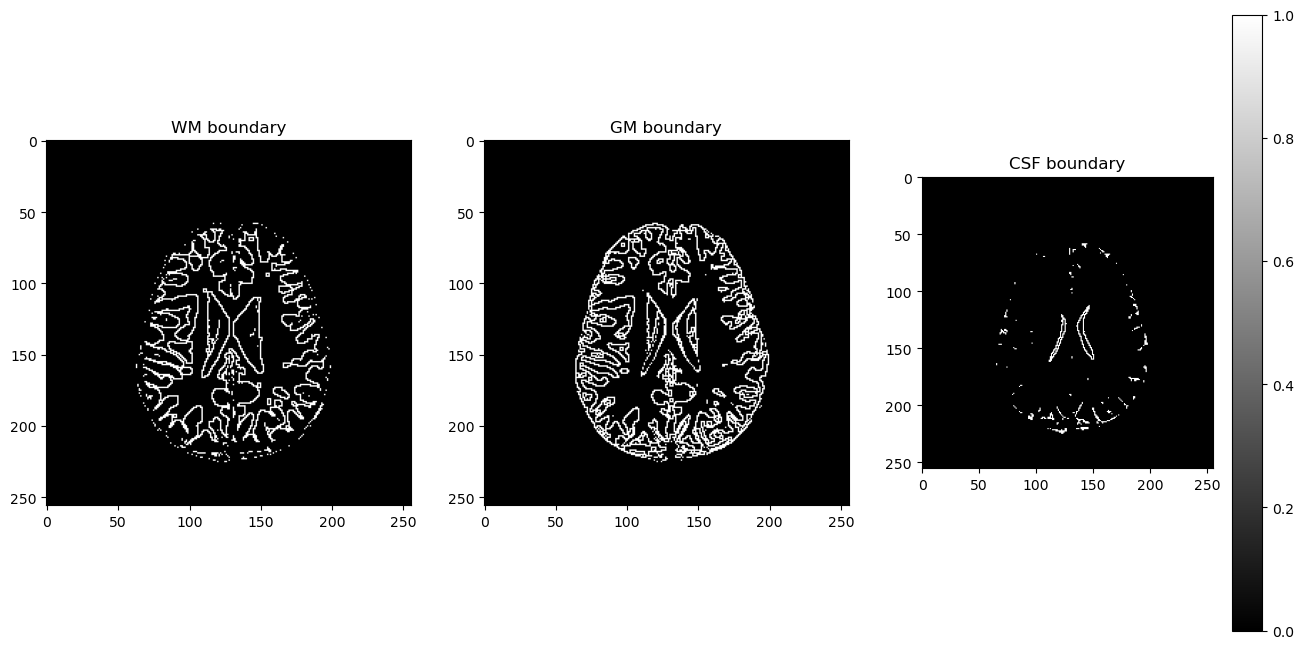

## surface area features s01 ##
WM surface area: 6538.0, GM surface area: 9538.0, CSF surface area: 1410.0


In [79]:
#surface area
custom_kernel = np.ones((3,3))

wm_boundary_plot, wm_boundary_cal = boundary_extraction(R, dv1, custom_kernel, 1)  
gm_boundary_plot, gm_boundary_cal = boundary_extraction(R, dv1, custom_kernel, 2)  
csf_boundary_plot, csf_boundary_cal = boundary_extraction(R, dv1, custom_kernel, 3)  

plot_boundary_2d(wm_boundary_plot, gm_boundary_plot, csf_boundary_plot)

print(f'## surface area features s01 ##')
print(f'WM surface area: {wm_boundary_cal}, GM surface area: {gm_boundary_cal}, CSF surface area: {csf_boundary_cal}')

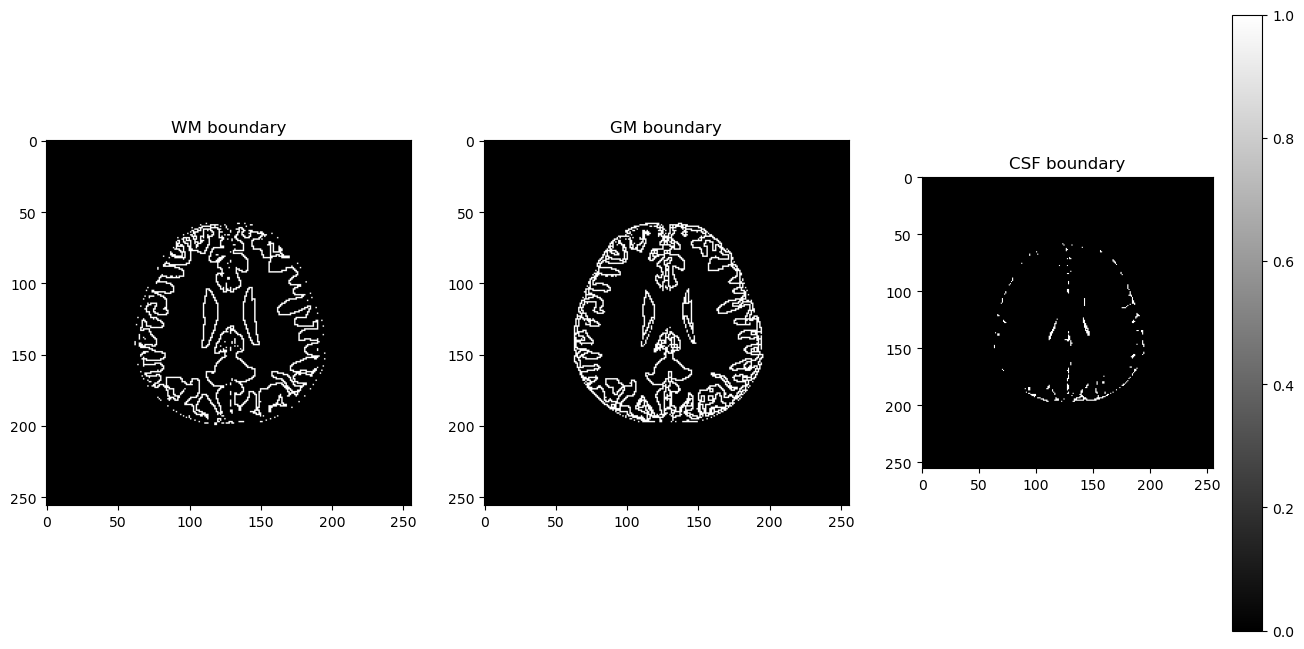

## surface area features s02 ##
WM surface area: 4857.977124810219, GM surface area: 6983.96711397171, CSF surface area: 889.9958091974258


In [80]:
#surface area
custom_kernel = np.ones((3,3))

wm_boundary_plot2, wm_boundary_cal2 = boundary_extraction(R2, dv2, custom_kernel, 1)  
gm_boundary_plot2, gm_boundary_cal2 = boundary_extraction(R2, dv2, custom_kernel, 2)  
csf_boundary_plot2, csf_boundary_cal2 = boundary_extraction(R2, dv2, custom_kernel, 3)  

plot_boundary_2d(wm_boundary_plot2, gm_boundary_plot2, csf_boundary_plot2)

print(f'## surface area features s02 ##')
print(f'WM surface area: {wm_boundary_cal2}, GM surface area: {gm_boundary_cal2}, CSF surface area: {csf_boundary_cal2}')

### Sphericity

In [81]:
# sphericity
wm_sph = (np.pi**(1/3))*((6*wm_vol)**(2/3))/wm_boundary_cal
gm_sph = (np.pi**(1/3))*((6*gm_vol)**(2/3))/gm_boundary_cal
csf_sph = (np.pi**(1/3))*((6*csf_vol)**(2/3))/csf_boundary_cal
print(f'## sphericity features s01 ##')
print(f'WM sph: {wm_sph}, GM sph: {gm_sph}, CSF sph: {csf_sph}')
wm_sph2 = (np.pi**(1/3))*((6*wm_vol2)**(2/3))/wm_vol2
gm_sph2 = (np.pi**(1/3))*((6*gm_vol2)**(2/3))/gm_vol2
csf_sph2 = (np.pi**(1/3))*((6*csf_vol2)**(2/3))/csf_vol2
print(f'## sphericity features s02 ##')
print(f'WM sph: {wm_sph2}, GM sph: {gm_sph2}, CSF sph: {csf_sph2}')

## sphericity features s01 ##
WM sph: 0.5079149768258966, GM sph: 0.3189270859984195, CSF sph: 0.4935057374316843
## sphericity features s02 ##
WM sph: 0.18473965699101122, GM sph: 0.21863295749803877, CSF sph: 0.49977601163917257


### Compactness 1

In [82]:
# compactness
wm_first_comp = (wm_sph**(3/2))/(np.pi * 6)
gm_first_comp = (gm_sph**(3/2))/(np.pi * 6)
csf_first_comp = (csf_sph**(3/2))/(np.pi * 6)
print(f'## 1th compactness features s01 ##')
print(f'WM comp: {wm_first_comp}, GM comp: {gm_first_comp}, CSF comp: {csf_first_comp}')
wm_first_comp2 = (wm_sph2**(3/2))/(np.pi * 6)
gm_first_comp2 = (gm_sph2**(3/2))/(np.pi * 6)
csf_first_comp2 = (csf_sph2**(3/2))/(np.pi * 6)
print(f'## 1th compactness features s02 ##')
print(f'WM comp: {wm_first_comp2}, GM comp: {gm_first_comp2}, CSF comp: {csf_first_comp2}')


## 1th compactness features s01 ##
WM comp: 0.019203721782904894, GM comp: 0.009555116446733621, CSF comp: 0.018392348443080783
## 1th compactness features s02 ##
WM comp: 0.004212491875902471, GM comp: 0.0054234085488840894, CSF comp: 0.018743987558101763


### Compactness 2

In [83]:
wm_second_comp = wm_sph ** 3
gm_second_comp = gm_sph ** 3
csf_second_comp = csf_sph ** 3
print(f'## 2nd compactness features s01 ##')
print(f'WM comp: {wm_second_comp}, GM comp: {gm_second_comp}, CSF comp: {csf_second_comp}')
wm_second_comp2 = wm_sph2 ** 3
gm_second_comp2 = gm_sph2 ** 3
csf_second_comp2 = csf_sph2 ** 3
print(f'## 2nd compactness features s02 ##')
print(f'WM comp: {wm_second_comp2}, GM comp: {gm_second_comp2}, CSF comp: {csf_second_comp2}')

## 2nd compactness features s01 ##
WM comp: 0.13103069875508466, GM comp: 0.03243950468231207, CSF comp: 0.12019229234480032
## 2nd compactness features s02 ##
WM comp: 0.006304931880964116, GM comp: 0.01045073628541252, CSF comp: 0.12483208397432044
